# SNA Project - Adam Steciuk

# Part 1
## Data collection

I decided to create the dataset used for the project myself. I used the [Reddit API](https://www.reddit.com/dev/api/) and Python library wrapper called [Praw](https://praw.readthedocs.io/en/stable/index.html).

The data I wanted to collect was posts from different subreddits. My methodology for collecting the data was as follows:
1. Start with a queue with one subreddit.
2. Take the first subreddit from the queue.
3. Collect the top `NUM_POSTS_FROM_SUB` posts from the subreddit.
4. Disregard posts from users that have less than `MIN_TIMES_POSTED` posts in those `NUM_POSTS_FROM_SUB` posts.
5. For each user that is left, collect the top `NUM_POSTS_FROM_USER` posts from their profile and add the subreddits they are posted in to the queue if they weren't already visited.
6. Repeat steps 2-5 until the queue is empty or the subreddits that processed are further than `MAX_DEPTH` from the starting subreddit.

In order for the following code to work, you need to create a file called `reddit_secrets.py` in the same directory as this notebook. The file should contain the secrets you [got from reddit](https://www.reddit.com/prefs/apps/) when you created your app. The file should look like this:
```python
CLIENT_ID = "XXXXXXXXXXXXXXXXXXX"
CLIENT_SECRET = "XXXXXXXXXXXXXXXXXXXXXXXXXXXX"
USER_AGENT = "your_app_name"
```

In [21]:
import praw
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import numpy as np
import nxviz as nv

# Import the secrets
from reddit_secrets import CLIENT_ID, CLIENT_SECRET, USER_AGENT

c:\RZECZY\CODING\SNA-project\.venv\Lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
# Directory for raw data
DATA_DIRECTORY = 'data'
# Directory for processed data used in Cytoscape
NETWORKS_DIRECTORY = 'networks'

DATA_PATH = os.path.join(os.getcwd(), DATA_DIRECTORY)
NETWORKS_PATH = os.path.join(os.getcwd(), NETWORKS_DIRECTORY)

if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)

if not os.path.exists(NETWORKS_PATH):
    os.mkdir(NETWORKS_PATH)

The script below was running for about 8h on my machine before it encountered an internal server error from Reddit. Unfortunately it didn't even managed to process all subreddits at depth 2. I decided to create a method that would allow me to resume the process from the last subreddit that was processed. That also allows me to stop and resume the process on demand.

The script at the start tries to load the state from the pickle file. If it fails, it means that the file doesn't exist and the script starts from scratch. If it succeeds, it means that the file exists and the script resumes from the last subreddit that was processed.

In [3]:
# SCRIPT_SAVE_PATH = os.path.join(os.getcwd(), 'script_save.pkl')
# script_save = None
# try:
#     with open(SCRIPT_SAVE_PATH, 'rb') as f:
#         script_save = pickle.load(f)

#     print("Loaded script save. Resuming...")
#     print("NUM_POSTS_FROM_SUB:", script_save["NUM_POSTS_FROM_SUB"])
#     print("NUM_POSTS_OF_USER:", script_save["NUM_POSTS_OF_USER"])
#     print("MIN_TIMES_POSTED:", script_save["MIN_TIMES_POSTED"])
#     print("MAX_DEPTH:", script_save["MAX_DEPTH"])
#     print("Number of subreddits in queue:", len(script_save["sub_q"]))
#     print("Number of posts saved so far:", script_save["num_posts_saved"])
# except:
#     print("No script save found. Starting from scratch...")
    

# NUM_POSTS_FROM_SUB = 500 if script_save is None else script_save["NUM_POSTS_FROM_SUB"]
# NUM_POSTS_OF_USER = 5 if script_save is None else script_save["NUM_POSTS_OF_USER"]
# MIN_TIMES_POSTED = 2 if script_save is None else script_save["MIN_TIMES_POSTED"]
# MAX_DEPTH = 5 if script_save is None else script_save["MAX_DEPTH"]

# sub_q = ["programming"] if script_save is None else script_save["sub_q"]
# sub_depths = {sub_q[0]: 0} if script_save is None else script_save["sub_depths"]
# skipped_subs = [] if script_save is None else script_save["skipped_subs"]

# reddit = praw.Reddit(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, user_agent=USER_AGENT)

# num_posts_saved = 0 if script_save is None else script_save["num_posts_saved"]

# # BFS; take the first subreddit from the queue.
# while len(sub_q) > 0 and (sub:=sub_q.pop(0)):
#     print("=========================================")
#     print(f"Processing '{sub}' on depth {sub_depths[sub]}")
#     print(f"Queue size: {len(sub_q)}")
#     print(f"Num posts saved so far: {num_posts_saved}")

#     posts = None
#     try:
#         # Download posts from the subreddit
#         posts = list(reddit.subreddit(sub).top(limit=NUM_POSTS_FROM_SUB, time_filter="all"))
#     except:
#         print(f"ERROR: Cannot access '{sub}'")
#         skipped_subs.append(sub)

#     if posts is not None:
#         if len(posts) < NUM_POSTS_FROM_SUB:
#             print(f"Only {len(posts)} posts found")

#         data_df = pd.DataFrame(
#             [[post.title, post.score, post.id, post.url, post.num_comments, post.created, post.author, post.upvote_ratio, post.permalink, post.subreddit, post.subreddit_subscribers, sub_depths[sub]] for post in posts],
#             columns=["title", "score", "id", "url", "num_comments", "created", "author", "upvote_ratio", "permalink", "subreddit", "subreddit_subscribers", "depth"],
#         )

#         # Filter out posts made by deleted users
#         data_df = data_df[data_df["author"].notna()]

#         # Keep only authors that posted more then MIN_TIMES_POSTED times
#         data_df["author_name"] = data_df["author"].apply(lambda x: x.name)
#         data_df = data_df.groupby("author_name").filter(lambda x: len(x) >= MIN_TIMES_POSTED)
#         data_df = data_df.drop(columns=["author_name"])

#         authors = data_df["author"].unique()
#         num_posts = len(data_df)
#         num_posts_saved += num_posts
#         print(f"Num posts after filtering out: {num_posts} from {len(authors)} authors")

#         # Check if we reached the max depth
#         if sub_depths[sub] >= MAX_DEPTH:
#             print("Max depth reached")
#         else:
#             for author in authors:
#                 try:
#                     # Try to get submissions of the author
#                     user_submissions = list(author.submissions.top(limit=NUM_POSTS_OF_USER, time_filter="all"))

#                     # Extract subreddits from top user submissions and add them to the queue
#                     for submission in user_submissions:
#                         sub_name = submission.subreddit.display_name
#                         if sub_name not in sub_depths:
#                             sub_q.append(sub_name)
#                             sub_depths[sub_name] = sub_depths[sub] + 1
#                 except:
#                     print(f"ERROR: User submissions are private for '{author}'")

#         # Save dataframe to csv
#         data_df.to_csv(f"{DATA_PATH}/posts_{sub}.csv", index=False)

#     # Save the script state to be able to resume in case of an error
#     script_save = {
#         "NUM_POSTS_FROM_SUB": NUM_POSTS_FROM_SUB,
#         "NUM_POSTS_OF_USER": NUM_POSTS_OF_USER,
#         "MIN_TIMES_POSTED": MIN_TIMES_POSTED,
#         "MAX_DEPTH": MAX_DEPTH,
#         "sub_q": sub_q,
#         "sub_depths": sub_depths,
#         "num_posts_saved": num_posts_saved,
#         "skipped_subs": skipped_subs,
#     }

#     with open(SCRIPT_SAVE_PATH, 'wb') as f:
#         pickle.dump(script_save, f)


I decided to stop the script manually after it collected around 150k posts even though it didn't reach the maximum depth. It took about 20h to collect that amount of data. I think that's enough for the project.

## Data processing and analysis

In [4]:
# Create the main dataframe
posts_df = pd.DataFrame()

# Load all the raw csv files into the main dataframe
for _root, _dirs, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith(".csv"):
            posts_df = pd.concat([posts_df, pd.read_csv(os.path.join(DATA_PATH, file))], ignore_index=True)

display(posts_df.info())
display(posts_df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149894 entries, 0 to 149893
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   title                  149894 non-null  object 
 1   score                  149894 non-null  object 
 2   id                     149894 non-null  object 
 3   url                    149894 non-null  object 
 4   num_comments           149894 non-null  object 
 5   created                149894 non-null  float64
 6   author                 149894 non-null  object 
 7   upvote_ratio           149894 non-null  float64
 8   permalink              149894 non-null  object 
 9   subreddit              149894 non-null  object 
 10  subreddit_subscribers  149894 non-null  object 
 11  depth                  149894 non-null  object 
dtypes: float64(2), object(10)
memory usage: 13.7+ MB


None

,title,score,id,url,num_comments,created,author,upvote_ratio,permalink,subreddit,subreddit_subscribers,depth
89237,Breath of the Wild sequel delayed to spring 2023,31147,tr0fsi,https://twitter.com/NintendoAmerica/status/150...,2890,1.648562e+09,dorkmax_executives,0.93,/r/NintendoSwitch/comments/tr0fsi/breath_of_th...,NintendoSwitch,4498700,2
27900,What do you think?,83,gggj99,https://v.redd.it/h7cwtgw24rx41,8,1.589035e+09,johnterry870,0.99,/r/Cosmos/comments/gggj99/what_do_you_think/,Cosmos,26660,2
147171,Top Iranian Presidential Adviser Says Tehran's...,107738,ekwlgd,https://www.newsweek.com/top-iran-adviser-pres...,8568,1.578329e+09,maxwellhill,0.84,/r/worldnews/comments/ekwlgd/top_iranian_presi...,worldnews,31254657,1
26356,Google Introduces Huge Universal Language Tran...,312,dprkfx,https://medium.com/syncedreview/google-introdu...,10,1.572546e+09,Yuqing7,0.97,/r/compsci/comments/dprkfx/google_introduces_h...,compsci,2152393,2
77581,Do you think we will be getting some crucial u...,123,ueinrr,https://i.redd.it/cmozrjoh0gw81.jpg,12,1.651227e+09,AMKW23,0.99,/r/McLarenFormula1/comments/ueinrr/do_you_thin...,McLarenFormula1,19936,2


The data I decided to collect has the following columns:
* `title` - title of the post
* `score` - score of the post
* `id` - id of the post
* `url` - url to content shared in the post (image, video, etc.)
* `num_comments` - number of comments on the post
* `created` - timestamp of the post creation
* `author` - author of the post
* `upvote_ratio` - ratio of upvotes to downvotes on the post
* `permalink` - url to the post
* `subreddit` - subreddit the post was posted in
* `subreddit_subscribers` - number of subscribers to the subreddit the post was posted in
* `depth` - depth of the subreddit from the starting subreddit

During creation of the networks presented in the next sections of the project I discovered some anomalies. After several hours of investigation I realized that some subreddits names and usernames are the same. That leads to problems with node identification in the network. I decided to add a prefix to the subreddit names and usernames to avoid those problems. The prefix for subreddits is `r/` and for usernames is `u/`. This will solve the problem as `/` is not allowed in subreddit names and usernames.

In [5]:
posts_df["subreddit"] = posts_df["subreddit"].apply(lambda x: f"r/{x}")
posts_df["author"] = posts_df["author"].apply(lambda x: f"u/{x}")
posts_df.sample(5)

,title,score,id,url,num_comments,created,author,upvote_ratio,permalink,subreddit,subreddit_subscribers,depth
17609,Ten reasons why a 'Greater Depression' for the...,7,gaahd6,https://www.theguardian.com/business/2020/apr/...,0,1.588171e+09,u/eleitl,1.00,/r/BottleNeck/comments/gaahd6/ten_reasons_why_...,r/BottleNeck,2291,2
128814,Masai's reaction to Lowry lifting up the Larry...,1975,c0pn1y,https://gfycat.com/revolvinguniqueladybird,50,1.560548e+09,u/suzukigun4life,0.99,/r/torontoraptors/comments/c0pn1y/masais_react...,r/torontoraptors,380953,2
70417,Positive outlook,25952,b7c6dx,https://i.redd.it/gqqcrysys9p21.png,347,1.553958e+09,u/nokia621,0.87,/r/LateStageCapitalism/comments/b7c6dx/positiv...,r/LateStageCapitalism,837508,2
12682,/u/goatcoat explains why Melania Trump had suc...,15944,90ls2t,https://np.reddit.com/r/gifs/comments/90jfr8/m...,1254,1.532138e+09,u/InternetWeakGuy,0.59,/r/bestof/comments/90ls2t/ugoatcoat_explains_w...,r/bestof,5361354,1
40480,Aww ! they went on a double date,2684,kfhi92,https://i.redd.it/xmmjbvptrw561.png,78,1.608281e+09,u/SHADYP00L,0.99,/r/Eminem/comments/kfhi92/aww_they_went_on_a_d...,r/Eminem,266188,2


In [6]:
num_subredits = len(posts_df["subreddit"].unique())
num_authors = len(posts_df["author"].unique())
num_posts = len(posts_df)

print(f"Collected {num_posts} posts from {num_subredits} subreddits and {num_authors} authors")

Collected 149894 posts from 1030 subreddits and 32311 authors


Let's analyze the number of posts collected from each subreddit.

,subreddit,num_posts
120,r/Deltarune,204
345,r/ShingekiNoKyojin,158
1012,r/wholesomememes,86
47,r/Awwducational,283
729,r/nevertellmetheodds,84
336,r/SandersForPresident,268
511,r/confusing_perspective,39
908,r/travisscott,101
93,r/Cinema4D,291
371,r/TIHI,79


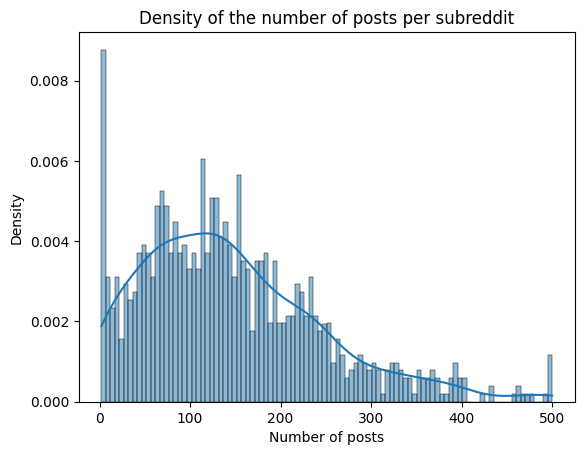

In [7]:
num_posts_per_sub = posts_df.groupby("subreddit").size().reset_index(name="num_posts")
display(num_posts_per_sub.sample(10))

# plot the density of the number of posts per subreddit
sns.histplot(num_posts_per_sub["num_posts"], stat="density", bins=100, kde=True)
plt.title("Density of the number of posts per subreddit")
plt.xlabel("Number of posts")
plt.ylabel("Density")
plt.show()


Because we decided to collect 500 posts from each subreddit (`NUM_POSTS_FROM_SUB`) and then disregarded posts from users that have less than 2 posts in that subreddit (`MIN_TIMES_POSTED`), the number of posts will always be 500 or less. If the subreddit has exactly 500 posts, that means that all the most popular posts were made by the same user. That would be highly unlikely for popular subreddits visited by many different people, so probably the subreddits from which we collected near to 500 posts are less popular. Let's check that.

In order to do that let's create a dataframe with number of subscribers of each subreddit. We have to use mean function and then round the result because during the data collection process the number of subscriber could have changed.

In [8]:
num_subscribers_per_sub = posts_df.groupby("subreddit").agg("subreddit_subscribers").mean().round().astype(int).reset_index(name="subscribers")
display(num_subscribers_per_sub.sample(10))

,subreddit,subscribers
479,r/blursedimages,3367512
155,r/FaviFake,27
238,r/MEOW_IRL,455935
838,r/skyrim,1445471
153,r/FallenOrder,159651
575,r/fifthworldproblems,170143
50,r/Barotrauma,42723
139,r/Economics,3173252
750,r/oddlysatisfying,9171568
757,r/outrun,407764


Let's plot the number of posts collected from each subreddit against the number of subscribers to that subreddit. We have to use log scale for x axis because the number of subscribers is very skewed. **As we cannot have value of 0 on log scale, we have to add 1 to the number of subscribers.**

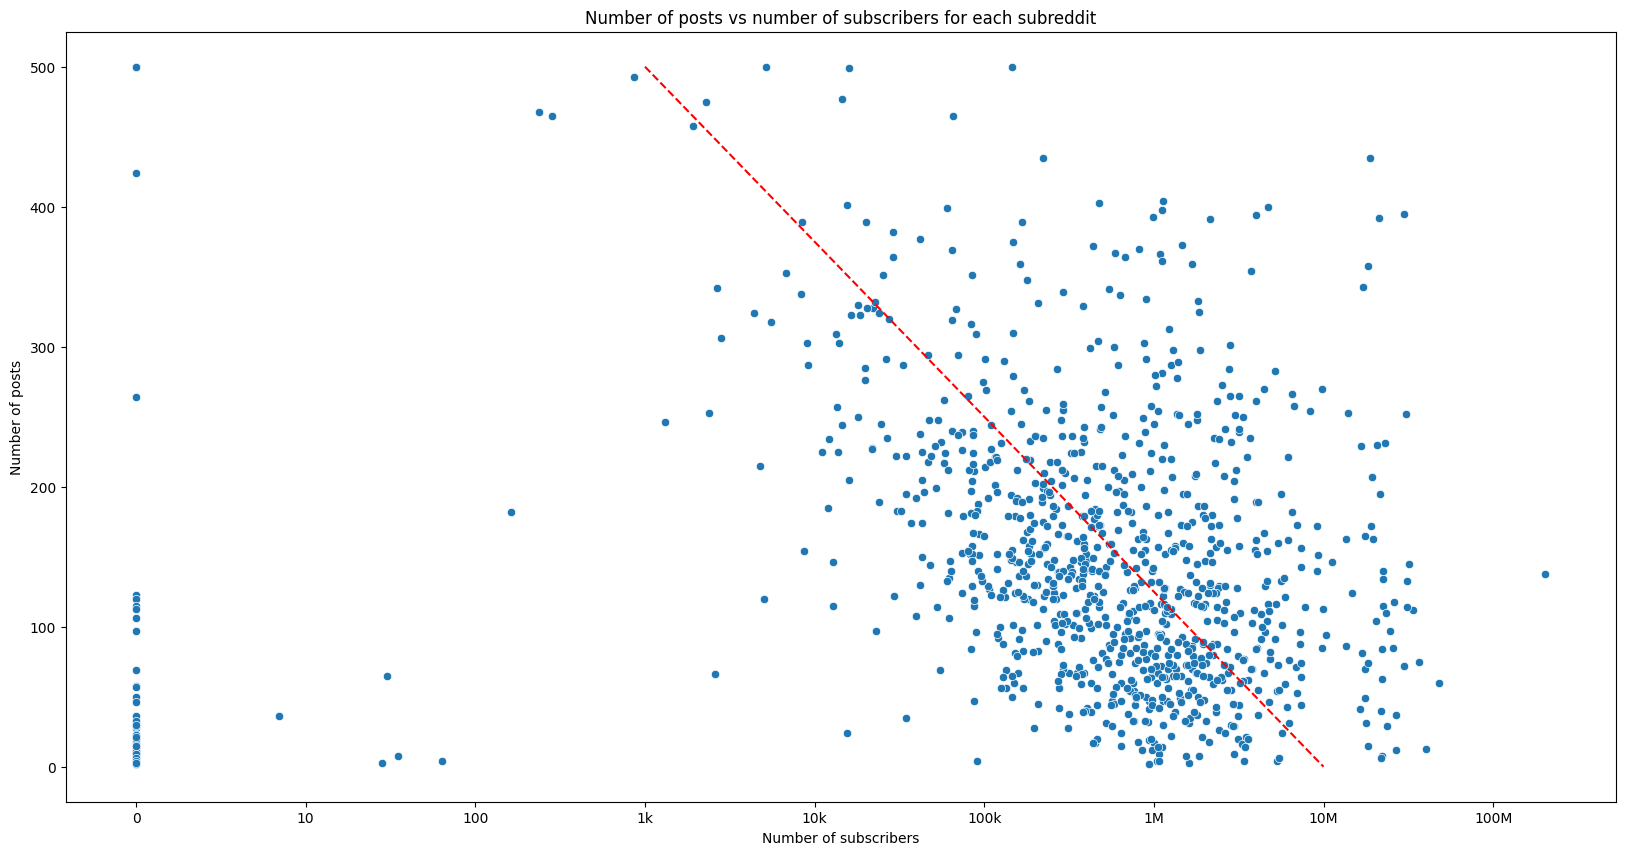

In [9]:
num_posts_and_subscribers_per_sub = num_posts_per_sub.merge(num_subscribers_per_sub, on="subreddit")
num_posts_and_subscribers_per_sub["subscribers"] += 1

plt.figure(figsize=(20, 10))
sns.scatterplot(data=num_posts_and_subscribers_per_sub, x="subscribers", y="num_posts")
plt.xscale("log")
plt.title("Number of posts vs number of subscribers for each subreddit")
plt.xlabel("Number of subscribers")
plt.ylabel("Number of posts")
# set the xticks, taking into account the trick of adding 1 to the subscribers count
plt.xticks([10**i for i in range(9)], ["0", "10", "100", "1k", "10k", "100k", "1M", "10M", '100M'])

# plot the line to show the tendency of the data
plt.plot([10**i for i in range(3, 8)], [500/4*(4-i) for i in range(5)], color="red", linestyle="--")

plt.show()

We can see that the hypothesis is somewhat correct. Points in the most dense part of the graph tend to align with it (red dashed line). 

Let's plot the distribution of the number of subscribers to subreddits from which we collected posts. We have already created the dataframe for the previous plot, so we can just use it. The plot below shows why we had to use log scale for the previous plot.

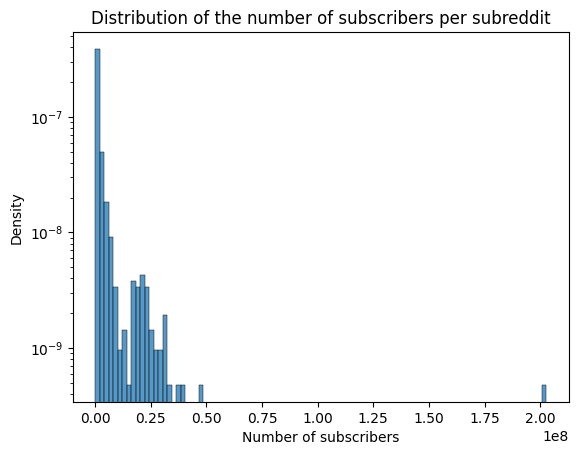

In [10]:
sns.histplot(num_subscribers_per_sub["subscribers"], log_scale=(False, True), stat="density", bins=100)
plt.title("Distribution of the number of subscribers per subreddit")
plt.xlabel("Number of subscribers")
plt.ylabel("Density")
plt.show()

Let's see the distribution of number of subreddits each user posted in. That is important as the number of subreddits each user posted in is the number of edges that will be created for the node representing that user (its degree) in the bipartite network presented in the next section.

,author,num_subs
0,u/My_Memes_Will_Cure_U,63
1,u/Master1718,60
2,u/memezzer,49
3,u/KevlarYarmulke,47
4,u/5_Frog_Margin,45
5,u/GallowBoob,40
6,u/Scaulbylausis,36
7,u/kevinowdziej,33
8,u/icant-chooseone,29
9,u/AristonD,28


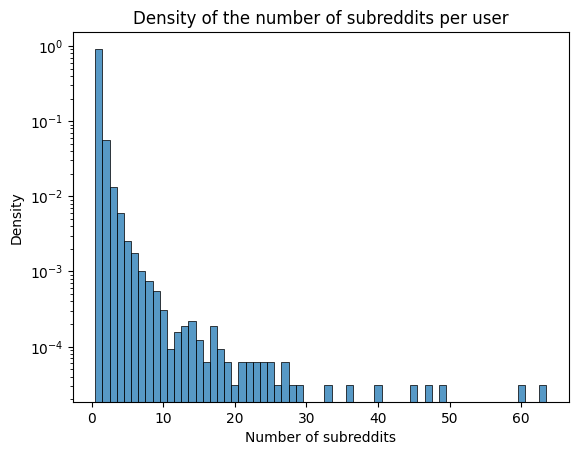

In [11]:
num_subs_per_user = posts_df.groupby(["author", "subreddit"]).size().groupby("author").size().sort_values(ascending=False).reset_index(name="num_subs")
display(num_subs_per_user.head(10))
# plot the density of the number of subreddits per author in log scale
sns.histplot(num_subs_per_user["num_subs"], discrete=True, stat="density", log_scale=(False, True))
plt.xlabel("Number of subreddits")
plt.title("Density of the number of subreddits per user")
plt.show()

We can see that user `u/My_Memes_Will_Cure_U` is the user that posted in the most subreddits. That means that the node representing that user will have the highest degree among all nodes representing users in the bipartite network.

Let's see the distribution of number of posts collected for each user.

,author,num_posts
0,u/SrGrafo,1077
1,u/GallowBoob,1069
2,u/Andromeda321,775
3,u/Yellyvi,763
4,u/My_Memes_Will_Cure_U,725
5,u/Unicornglitteryblood,516
6,u/pdwp90,506
7,u/ZadocPaet,485
8,u/mvea,450
9,u/flovringreen,430


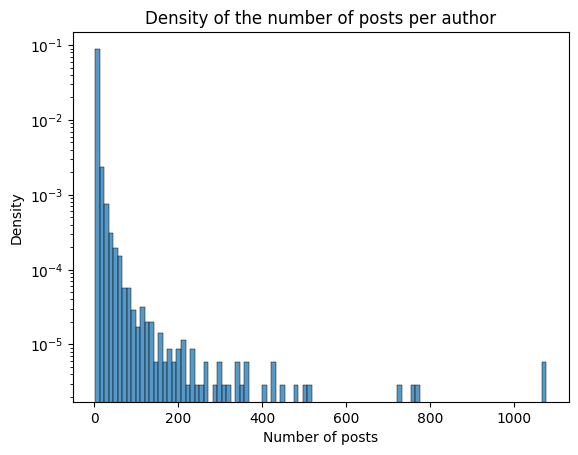

In [12]:
# plot the distribution of the number of posts per author
num_posts_per_user = posts_df.groupby("author").size().sort_values(ascending=False).reset_index(name="num_posts")
display(num_posts_per_user.head(10))

sns.histplot(num_posts_per_user["num_posts"], stat="density", bins=100)
plt.yscale("log")
plt.title("Density of the number of posts per author")
plt.xlabel("Number of posts")
plt.ylabel("Density")
plt.show()

We can see that the user `u/My_Memes_Will_Cure_U` is quite high up on the list. Another interesting fact is that we can observe an almost empty area on the x axis from around 500 posts to 1000 posts and then a sudden spike. That means that most of the users are somewhat active and a few users are extremely active on Reddit and there aren't many users in between.

We can also plot the number of posts each user posted in against the number of subreddits each user posted in. In that way we can see if there is any correlation between those two values. We will also plot the line `y = x/2` as each user had to post at least 2 (`MIN_TIMES_POSTED`) times in a given subreddit to be included in the dataset.

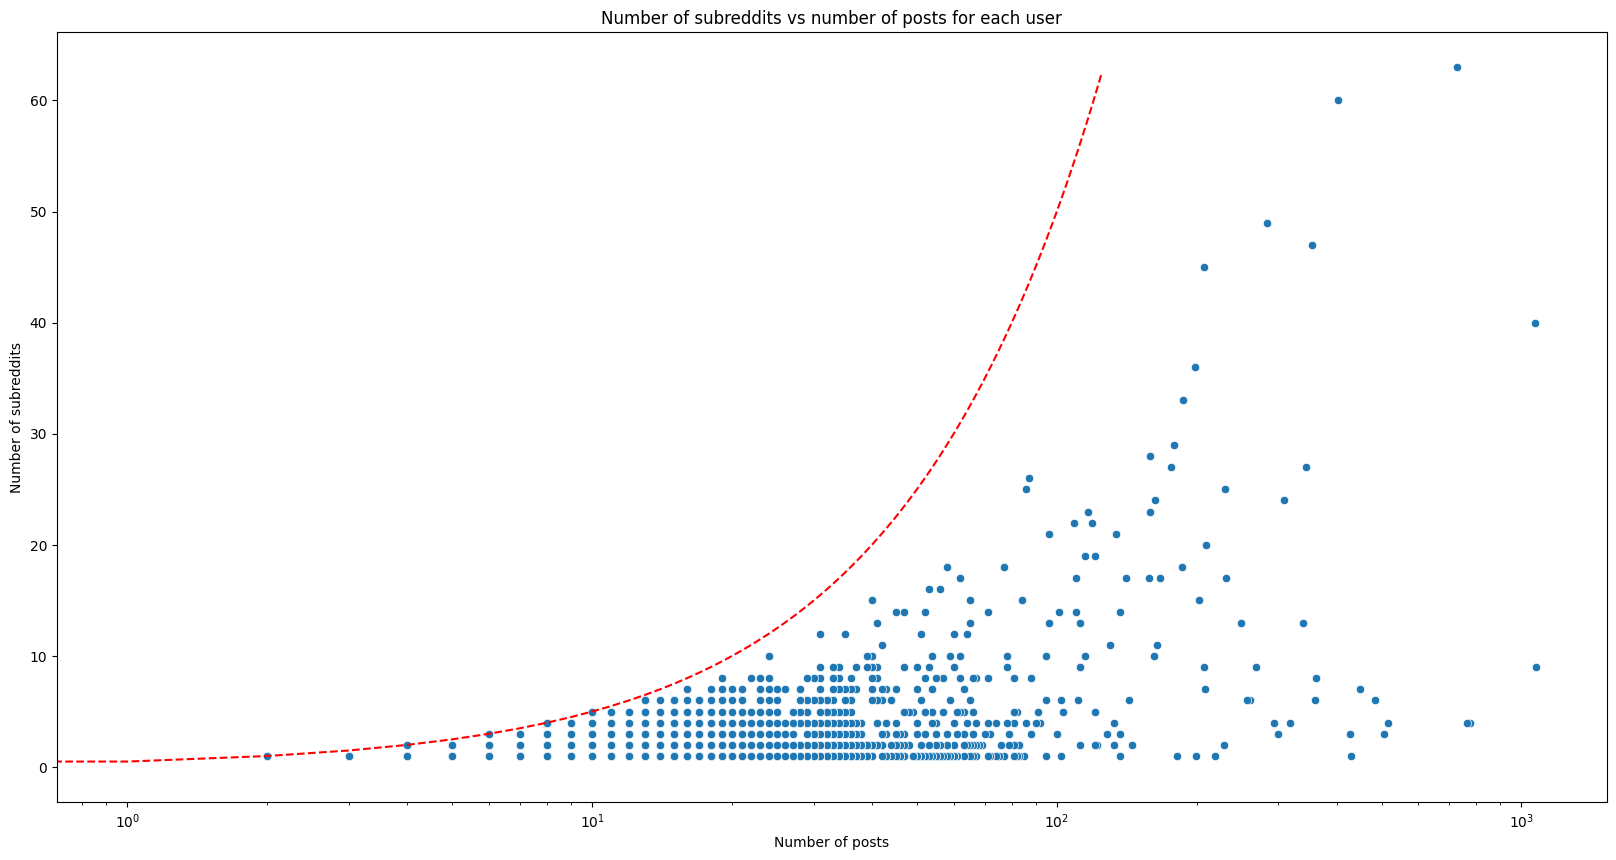

In [13]:
# plot the number of posts of each user against the number of subreddits they posted in
num_posts_and_subs_per_user = num_posts_per_user.merge(num_subs_per_user, on="author")

plt.figure(figsize=(20, 10))
sns.scatterplot(data=num_posts_and_subs_per_user, x="num_posts", y="num_subs")
plt.xscale("log")
plt.title("Number of subreddits vs number of posts for each user")
plt.xlabel("Number of posts")
plt.ylabel("Number of subreddits")

# plot y = 2x
x = [i for i in range(num_subs_per_user["num_subs"].max() * 2)]
plt.plot(x, [i/2 for i in x], color="red", linestyle="--")

plt.show()

Number of users that posted in each subreddit will also be important for the bipartite network as it will determine the number of edges that will be created for the node representing that subreddit (its degree). Let's see the distribution of that. Remember that we disregarded users that posted less than 2 (`MIN_TIMES_POSTED`) times in the subreddit and we collected 500 (`NUM_POSTS_FROM_SUB`) posts from each subreddit so the maximum number of users that posted in a subreddit is 250 (that would mean that each user created exactly 2 posts among those 500 top posts).

,subreddit,num_users
0,r/generative,93
1,r/Unity2D,92
2,r/avatartrading,81
3,r/Cinema4D,81
4,r/dalmatians,80
5,r/KTMDuke,80
6,r/ukraine,80
7,r/turning,78
8,r/animation,78
9,r/Simulated,78


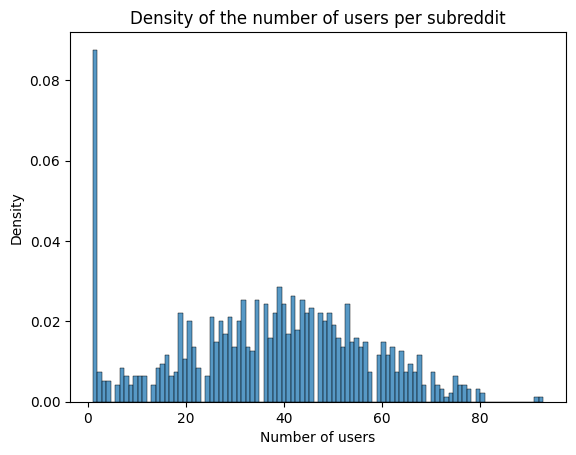

In [14]:
num_users_per_sub = posts_df.groupby(["subreddit", "author"]).size().groupby("subreddit").size().sort_values(ascending=False).reset_index(name="num_users")
display(num_users_per_sub.head(10))

sns.histplot(num_users_per_sub["num_users"], stat="density", bins=100)
# plt.yscale("log")
plt.title("Density of the number of users per subreddit")
plt.xlabel("Number of users")
plt.ylabel("Density")
plt.show()

We can see that the subreddit `r/generative` is the subreddit from which we collected posts from the highest number of users. That means that the node representing that subreddit will have the highest degree among all nodes representing subreddits in the bipartite network.

We can also notice, that the distribution follows a normal distribution quite well, with an expected value of around 40. There is, however, a huge spike at value of 1. That means that there are a lot of subreddits from which we collected posts from only one user. That would make sense as there are some subreddits that have restricted posting permissions. Usually they are used as a private boards of an user.

It is also worth noting that on big subreddits it is hard to get one's post to the top 500. It is quite common that each of those 500 posts is made by a different user. Because I decided to disregard posts of users that posted less than 2 times (`MIN_TIMES_POSTED`) in the subreddit, it is possible that usually there were only 1 user that managed to get 2 of his post to the top 500. Probably if we have removed that restriction, the distribution would have been much more right side heavy (in the area close to 500).

## Bipartite network of subreddits and users

### Creation

First network I decided to create is a bipartite network of subreddits and users. There will be an edge between a subreddit and a user if there are at least `MIN_TIMES_POSTED` posts from that user in that subreddit. There is also an edge attribute `num_posts` that stores the number of posts from that user in that subreddit. It can be then used to calculate the weight of the edge if needed.

In [15]:
# Create a dataframe with all the author-subreddit pairs
user_sub_pairs = posts_df.groupby(["author", "subreddit"]).size().reset_index(name="num_posts")
display(user_sub_pairs.head(10))

# Save the author-subreddit pairs to a csv file that could be imported to Cytoscape
user_sub_pairs.to_csv(f"{NETWORKS_PATH}/bipartite.csv", index=False)

,author,subreddit,num_posts
0,u/--5-,r/india,2
1,u/--CreativeUsername,r/Physics,2
2,u/--Fatal--,r/homelab,2
3,u/--MVH--,r/Netherlands,4
4,u/--Speed--,r/logodesign,2
5,u/--UNFLAIRED--,r/carscirclejerk,2
6,u/--Yami_Marik--,r/WatchPeopleDieInside,3
7,u/--Yami_Marik--,r/holdmycosmo,2
8,u/-AMARYANA-,r/Awwducational,2
9,u/-AMARYANA-,r/Buddhism,7


The next thing I decided to do was to create a csv files which contains the nodes' attributes that could be used to style the network in Cytoscape. First file contains the attributes of the subreddits:
* `id` - id of the node
* `is_user` - boolean value indicating if the node is a subreddit or a user, in this case it is always `false`
* `subscribers` - number of subscribers of a subreddit

Because we have already created a dataframe with number of subscribers of each subreddit, we can just use it to create the csv file.

In [16]:
# Rename the `subreddit` column to `id`
sub_data = num_subscribers_per_sub.rename(columns={"subreddit": "id"})
sub_data = sub_data.sort_values(by="subscribers", ascending=False)
# Add column `is_user` with value `False` to indicate that the nodes are subreddits
sub_data["is_user"] = False

display(sub_data.head(10))

# Save the dataframe to a csv file
sub_data.to_csv(f"{NETWORKS_PATH}/bipartite_sub_data.csv", index=False)

,id,subscribers,is_user
442,r/announcements,202719824,False
596,r/funny,48108476,False
42,r/AskReddit,40249936,False
604,r/gaming,36492322,False
461,r/aww,33655974,False
273,r/Music,32043294,False
1020,r/worldnews,31254656,False
899,r/todayilearned,31041441,False
720,r/movies,30617572,False
772,r/pics,29880182,False


The second file contains the attributes of the users:
* `id` - id of the node
* `is_user` - boolean value indicating if the node is a subreddit or a user, in this case it is always `true`
* `total_score` - total score of all posts of a user
* `num_posts` - total number of posts of a user

In [36]:
# Create a dataframe with author data and the total score of their posts
user_data = posts_df.groupby("author")["score"].sum().sort_values(ascending=False).reset_index()
user_data = user_data.merge(num_posts_per_user, on="author")
user_data = user_data.rename(columns={"score": "total_score", "author": "id"})

user_data["is_user"] = True
display(user_data.head(10))

# Save the dataframe to a csv file that could be imported to Cytoscape
user_data.to_csv(f"{NETWORKS_PATH}/bipartite_user_data.csv", index=False)

,id,total_score,num_posts,is_user
0,u/My_Memes_Will_Cure_U,28764321,725,True
1,u/beerbellybegone,24308427,260,True
2,u/mvea,20158958,450,True
3,u/GallowBoob,18798098,1069,True
4,u/SrGrafo,16470408,1077,True
5,u/Master1718,15458144,403,True
6,u/DaFunkJunkie,15101854,202,True
7,u/memezzer,11689024,283,True
8,u/unnaturalorder,10315964,158,True
9,u/kevinowdziej,9681202,187,True


I imported the `user_sub_pairs` dataframe from the previous section to Cytoscape but because the number of nodes was too big, Cytoscape was not able to calculate even the default (initial) layout. All the nodes were stacked on top of each other. I tried different layouts but the only one that managed to finish calculating itself was the circular layout. I decided to use that layout for the visualization of the network.

Furthermore, because of the problem with visualization, I decided to create a smaller network that could be visualized with other layouts. After filtrating out the posts from subreddits on depth 3 and above and posts in subreddits that have less than 500000 subscribers we are left with 57800 posts. That number of nodes created from those posts Cytoscape is able to process.

In [18]:
posts_df_filtered = posts_df[posts_df["depth"] <= 2]
print("Num of posts after 'depth <= 2':", len(posts_df_filtered))
posts_df_filtered = posts_df_filtered[posts_df_filtered["subreddit_subscribers"] >= 500000]
print("Num of posts after 'subreddit_subscribers >= 500000':", len(posts_df_filtered))

user_sub_pairs_filtered = posts_df_filtered.groupby(["author", "subreddit"]).size().reset_index(name="num_posts")
display(user_sub_pairs_filtered.head(10))

# Save the author-subreddit pairs to a csv file that could be imported to Cytoscape
user_sub_pairs_filtered.to_csv(f"{NETWORKS_PATH}/bipartite_filtered.csv", index=False)

Num of posts after 'depth <= 2': 121426
Num of posts after 'subreddit_subscribers >= 500000': 57800


,author,subreddit,num_posts
0,u/--5-,r/india,2
1,u/--CreativeUsername,r/Physics,2
2,u/--Fatal--,r/homelab,2
3,u/--Yami_Marik--,r/WatchPeopleDieInside,3
4,u/--Yami_Marik--,r/holdmycosmo,2
5,u/-AMARYANA-,r/Awwducational,2
6,u/-AMARYANA-,r/Buddhism,7
7,u/-AMARYANA-,r/Futurology,3
8,u/-AMARYANA-,r/spaceporn,2
9,u/-ARIDA-,r/photography,2


### Cytoscape visualization

Below we cen see a visualization of the full bipartite network created in Cytoscape.
Styles used in the visualization:
* `is_user` - discrete mapping to colors: `blue` for `True` and `red` for `False`. (Red indicates that the node is a subreddit)
* `subscribers` - continuous mapping to sizes of the nodes.
* `num_posts` - continuous mapping to widths of the edges and their colors. (Darker and thicker edges indicate higher number of posts from a user in a subreddit)
* `total_score` - no mapping. I would like to map `total_score` to the size of the nodes if a node is a user and `subscribers` to the size of the nodes if a node is a subreddit but unfortunately I didn't find a way to do that.

![Bipartite network](img/bipartite.png)

As stated above circular layout is the only layout that managed to finish calculating itself. Nodes were sorted according to their type. We can see that all the edges from blue nodes (users) are pointing to the red ones (subreddits).

Below we can see a visualization of the smaller bipartite network created in Cytoscape. Styles used are the same as in the previous visualization.

![Bipartite filtered network](img/bipartite_filtered.png)

Data summary of both networks:

<style type="text/css">
.tg  {border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;}
.tg td{background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{background-color:#409cff;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#fff;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-yad6{background-color:#D2E4FC;border-color:#9abad9;text-align:left;vertical-align:top}
.tg .tg-hmp3{background-color:#D2E4FC;text-align:left;vertical-align:top}
.tg .tg-rx1i{border-color:#9abad9;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
.tg .tg-6578{border-color:#9abad9;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-rx1i" colspan="2"></th>
    <th class="tg-rx1i"># components</th>
    <th class="tg-rx1i"># nodes</th>
    <th class="tg-0lax"># users</th>
    <th class="tg-0lax"># subs</th>
    <th class="tg-rx1i"># edges</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-yad6" colspan="2">Unfiltered network</td>
    <td class="tg-yad6">51</td>
    <td class="tg-yad6">33 341</td>
    <td class="tg-hmp3">32 311</td>
    <td class="tg-hmp3">1 030</td>
    <td class="tg-yad6">38 054</td>
  </tr>
  <tr>
    <td class="tg-6578">-</td>
    <td class="tg-rx1i">Largest component</td>
    <td class="tg-rx1i">1</td>
    <td class="tg-rx1i">31 928</td>
    <td class="tg-0lax">30 950</td>
    <td class="tg-0lax">978</td>
    <td class="tg-rx1i">36 691</td>
  </tr>
  <tr>
    <td class="tg-yad6" colspan="2">Filtered network</td>
    <td class="tg-yad6">38</td>
    <td class="tg-yad6">13 166</td>
    <td class="tg-hmp3">12 707</td>
    <td class="tg-hmp3">459</td>
    <td class="tg-yad6">15 672</td>
  </tr>
  <tr>
    <td class="tg-6578">-</td>
    <td class="tg-rx1i">Largest component</td>
    <td class="tg-rx1i">1</td>
    <td class="tg-rx1i">12 507</td>
    <td class="tg-0lax">12 088</td>
    <td class="tg-0lax">419</td>
    <td class="tg-rx1i">15 050</td>
  </tr>
</tbody>
</table>

We can notice that the number of edges is much lower than Metcalfe's law for social network would predict. The number of edges is linearly proportional to the number of nodes (`~N`) and not to `N*log(N)`.

From the visualization of the filtered network we can see that it is mainly dissasortative by degree (a lot of star-like structures).

Other metrics relevant for the bipartite network (maximum degree of each partition, degree distributions across users and subreddits, etc.) were calculated in the previous section.

Metrics such as average degree, average clustering coefficient, average path length, etc. don't make much sense for bipartite networks and won't be analyzed here. I'll focus on them in the next section when we'll be analyzing subreddits and users projections.

Let's create the networkx graph of the network full network.

In [37]:
G = nx.Graph()
# Add nodes to the graph marking their partitions
for row in user_data.iterrows():
    G.add_node(row[1]["id"], bipartite="user", total_score=row[1]["total_score"], num_posts=row[1]["num_posts"])

for row in sub_data.iterrows():
    G.add_node(row[1]["id"], bipartite="sub", subscribers=row[1]["subscribers"])

# Add edges to the graph
for row in user_sub_pairs.iterrows():
    G.add_edge(row[1]["author"], row[1]["subreddit"], num_posts=row[1]["num_posts"])

# Add degree as a node attribute
for node in G.nodes():
    G.nodes[node]["degree"] = G.degree[node]

# Check if the graph is indeed bipartite
print(nx.is_bipartite(G))

True


## Users projection

Let's create the users projection of the network. The projection is a graph where nodes are users and edges are created between users if they have at least one common subreddit. That way we will get a network with nodes of the same type which will allow us to analyze other metrics and comparisons with model networks.

In [32]:
users_nodes = [node for node in G.nodes() if G.nodes[node]["bipartite"] == "user"]
G_users = nx.bipartite.projected_graph(G, users_nodes)

In [33]:
print("Number of nodes:", G_users.number_of_nodes())
print("Number of edges:", G_users.number_of_edges())

Number of nodes: 32311
Number of edges: 870230
